I compared the ICRF3 K catalog with the Gaia DR2 catalog (iers_auxilary).

In [1]:
from astropy.table import Table, join, Column
from astropy import units as u
import astropy.coordinates as coord
from astropy.coordinates import SkyCoord
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = "svg"
# My modules
# My modules
from my_progs.catalog.vsh_deg1_cor import vsh_deg01_fitting
from my_progs.catalog.vsh_deg2_cor import vsh_deg02_fitting, residual_calc02
from my_progs.catalog.pos_diff import nor_sep, pos_diff_calc
from my_progs.catalog.pos_err import pos_err_calc
from my_progs.catalog.write_output import print_vsh1_corr, print_vsh2_corr

In [2]:
icrf3_dat = "../data/icrf3k.txt"

# Read ICRF3 S/X catalog
icrf3 = Table.read(icrf3_dat,
                   format="ascii.fixed_width", data_start=16,
                   names=["icrf_name", "iers_name", "type",
                          "ra_err", "dec_err", "ra_dec_corr",
                          "mean_obs", "beg_obs", "end_obs",
                          "nb_sess", "nb_del"],
                   col_starts=[0, 25, 35, 83, 98,
                               108, 118, 127, 136, 145, 150],
                   col_ends=[20, 32, 35, 92, 106, 114, 124, 133, 142, 148, 155])

# Position information
ra_dec = Table.read(icrf3_dat,
                    format="ascii.fixed_width", data_start=16,
                    names=["ra_dec"], col_starts=[40], col_ends=[77])

ra_dec = SkyCoord(ra_dec["ra_dec"], unit=(u.hourangle, u.deg))
ra = Column(ra_dec.ra, name="ra")
dec = Column(ra_dec.dec, name="dec")

# Add source position to the table
icrf3.add_columns([ra, dec], indexes=[3, 3])

# Add unit information
icrf3["ra_err"] = icrf3["ra_err"] * 15e3 * np.cos(ra_dec.dec.rad)
icrf3["ra_err"].unit = u.mas
icrf3["dec_err"].unit = u.arcsec
icrf3["dec_err"] = icrf3["dec_err"].to(u.mas)

# Calculate the semi-major axis of error ellipse
pos_err = pos_err_calc(
    icrf3["ra_err"], icrf3["dec_err"], icrf3["ra_dec_corr"])

# Add the semi-major axis of error ellipse to the table
icrf3.add_column(pos_err, name="pos_err", index=9)
icrf3["pos_err"].unit = u.mas

In [3]:
# Read Gaia DR2 IERS quasar data
gaiadr2 = Table.read("../data/gaiadr2_iers.fits")
gaiadr2.colnames

['iers_name',
 'solution_id',
 'designation',
 'source_id',
 'random_index',
 'ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'parallax_over_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_bad_obs_al',
 'astrometric_gof_al',
 'astrometric_chi2_al',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_params_solved',
 'astrometric_primary_flag',
 'astrometric_weight_al',
 'astrometric_pseudo_colour',
 'astrometric_pseudo_colour_error',
 'mean_varpi_factor_al',
 'astrometric_matched_observations',
 'visibility_periods_used',
 'astrometric_sigma5d_max',
 'frame_rotator_object_type',
 'matched_observations',
 'duplicated_source',

In [4]:
# Only the positional information are kept.
gaiadr2.keep_columns(["iers_name", 
                      "source_id", 
                      "ra", 
                      "ra_error", 
                      "dec", 
                      "dec_error",
                      "parallax", 
                      "parallax_error",
                      "pmra",
                      "pmra_error",
                      "pmdec",
                      "pmdec_error",
                      "ra_dec_corr",
                      "ra_parallax_corr",
                      "ra_pmra_corr",
                      "ra_pmdec_corr",
                      "dec_parallax_corr",
                      "dec_pmra_corr",
                      "dec_pmdec_corr",
                      "parallax_pmra_corr",
                      "parallax_pmdec_corr",
                      "pmra_pmdec_corr"])

In [5]:
# Calculate the semi-major axis of error ellipse
pos_err = pos_err_calc(
    gaiadr2["ra_error"], gaiadr2["dec_error"], gaiadr2["ra_dec_corr"])

# Add the semi-major axis of error ellipse to the table
gaiadr2.add_column(pos_err, name="pos_err", index=6)
gaiadr2["pos_err"].unit = u.mas
gaiadr2

iers_name,source_id,ra,ra_error,dec,dec_error,pos_err,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr
,,deg,mas,deg,mas,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,
bytes8,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
2357-326,2314315845817748992,0.08499783888929553,0.1445922512977904,-32.35034287416735,0.12064481144837098,0.1459297058023392,0.2031436388244911,0.18931038055012414,-0.036379976508171166,0.2996915751383218,0.07511508120986538,0.2477794651372806,-0.092771634,0.3238576,0.26209354,-0.09424034,-0.37053558,-0.016644478,0.23910828,-0.04301203,-0.20278661,0.06913886
2358-161,2415835442333250688,0.2722030739253465,0.20602077902948293,-15.851965536926414,0.1283223830435575,0.20605283885027792,-0.055558146475727405,0.24401150977786393,-0.2358559729612182,0.3893762964882165,-0.6856420405574464,0.29947031486611997,0.02216497,0.3860851,0.3694782,-0.18911926,-0.25913212,0.07878281,0.59325767,-0.21182266,-0.5026838,0.31012946
2359-221,2340552087337605248,0.5499220984388309,0.4830680409810676,-21.8860734515098,0.3214542550971185,0.4831047772372843,-1.2254791228136077,0.5329940012064253,-0.034637706078405564,0.8855496468586489,-0.05961199228747711,0.7657056040084157,-0.013836138,0.39026165,0.44715494,-0.10128507,-0.081793234,0.007855844,0.5445474,-0.060944,-0.17351532,0.21098249
0000-199,2365814049884978048,0.8164555380378795,0.31214484752059934,-19.697333393384483,0.20132065134575663,0.31218319151974,-0.24976210176238237,0.36241695927078477,0.6167410883691041,0.5467370543754372,-0.20622857222487195,0.4638258235243829,0.01857697,0.46789265,0.3675997,-0.17307134,-0.20771366,0.066310346,0.5528602,-0.10075016,-0.40074503,0.2787808
0000-197,2365855384650325376,0.8278123681512258,0.2387757610163772,-19.456209949035525,0.1922200644996743,0.24241216451703895,-0.45544305828221626,0.3185109654739551,0.6116734571782345,0.5735415853774198,0.37085954108422414,0.39878223344506625,0.13461179,0.052950118,0.35212186,-0.022328816,-0.097155325,-0.019389542,0.2804625,-0.1926077,-0.35069835,0.24758662
0001-120,2421598528234887680,1.0204794846922574,0.3102386470908995,-11.816218379326092,0.29214212886423696,0.33998919727933147,0.06584825341243254,0.3640494710474267,0.049237658462576495,0.7606129274645607,0.44519648557145636,0.7265389349874076,0.26688337,0.16208343,0.33467895,0.089694664,-0.13309994,0.2532729,0.7076963,-0.11914465,-0.22260411,0.5138607
0001+459,387054966590038656,1.0671982239853723,0.7718284266351787,46.25499167308568,0.6969576827283192,0.777985787941841,-0.029368229696100832,1.0984495193905532,0.9944652987116404,1.2381622163997819,0.4579145221304079,0.9951609005577559,-0.06277916,0.42371804,-0.60506684,0.19084497,0.07386451,0.025139727,-0.6068582,-0.4637956,0.30770168,-0.2570573
0002-478,4978016560925910400,1.1485644787260738,0.32535001967377664,-47.60544549244506,0.38175267275937685,0.4046925099699907,-0.394507921304075,0.5551341682993441,0.10766725569112054,0.5623357858130931,-0.2990603581366252,0.6935629455335646,-0.2602696,0.38209838,-0.3261622,-0.043664124,-0.36382514,0.12289763,-0.07530141,-0.16826801,-0.2654429,-0.06584475


A crossmatch is performed to obtain a sample of common sources.

In [6]:
com_sou = join(icrf3, gaiadr2, keys="iers_name", table_names=["icrf3k", "gaiadr2"])
com_sou

icrf_name,iers_name,type,ra_icrf3k,dec_icrf3k,ra_err,dec_err,ra_dec_corr_icrf3k,mean_obs,pos_err_icrf3k,beg_obs,end_obs,nb_sess,nb_del,source_id,ra_gaiadr2,ra_error,dec_gaiadr2,dec_error,pos_err_gaiadr2,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr_gaiadr2,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr
,,,deg,deg,mas,mas,,,mas,,,,,,deg,mas,deg,mas,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,
str21,str8,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32
ICRF J000504.3+542824,0002+541,--,1.2681805876666665,54.473590121250005,0.07321584713652726,0.0905,0.0477,57561.2,0.09069246230326641,53898.6,58181.5,9,732,420305499589122944,1.2681808047501304,0.13120835916273907,54.47359019646749,0.13042564468464754,0.14545837311323823,-0.14358682773108555,0.19574910597769088,-0.03226026529765841,0.2462715837614524,-0.06292777713183365,0.23430898938890327,-0.23628916,0.25975955,-0.45651165,0.09144919,-0.2566045,0.0073146904,-0.41105396,-0.13174422,0.4187751,-0.12113201
ICRF J000435.6-473619,0002-478,D,1.1485647359583333,-47.60544541102778,0.4516681517736428,1.0827,0.6589,57961.2,1.1267942729306641,57599.3,58067.8,7,13,4978016560925910400,1.1485644787260738,0.32535001967377664,-47.60544549244506,0.38175267275937685,0.4046925099699907,-0.394507921304075,0.5551341682993441,0.10766725569112054,0.5623357858130931,-0.2990603581366252,0.6935629455335646,-0.2602696,0.38209838,-0.3261622,-0.043664124,-0.36382514,0.12289763,-0.07530141,-0.16826801,-0.2654429,-0.06584475
ICRF J000557.1+382015,0003+380,--,1.4882307991666666,38.3375413845,0.05294498242586314,0.07369999999999999,-0.1988,57909.1,0.07512354105978385,57372.1,58195.8,10,724,2880735415555982976,1.4882330572178368,0.2284371807502203,38.337539859379994,0.17763597364941844,0.22845829198943232,0.1593562094722022,0.3646175286281955,0.28592281784064194,0.43330939124983037,-0.26680058654512034,0.2873635197110239,-0.010995329,0.39091006,-0.22830355,0.044289686,0.058109067,-0.05278489,0.06332331,-0.313217,0.13932036,-0.18161543
ICRF J000613.8-062335,0003-066,--,1.5578870084583334,-6.393148817805556,0.047850566755598754,0.10609999999999999,-0.4903,57819.0,0.10909553579758349,56782.4,58181.5,9,658,2442050857556048000,1.5578870064695536,0.09430468606721869,-6.39314865050367,0.062095265856561006,0.09842497204589487,0.21968984080969833,0.1202299976697474,-0.2807910312361741,0.21287585729116837,-0.1650042495297552,0.12258446418311031,0.36748704,0.21541953,0.022390373,-0.16457231,-0.22921939,-0.14024962,0.367701,-0.062028516,-0.44003168,0.44253242
ICRF J000903.9+062821,0006+061,--,2.2663827199999997,6.472566606222222,0.11506188429537391,0.22569999999999998,-0.3528,57837.4,0.23032386525156387,52782.5,58195.8,7,316,2742639774468057984,2.266383380171318,0.17901906469996773,6.472567215998765,0.15313678236923897,0.22300503470053573,0.05677676624095592,0.20619087561598493,-0.33539524001957915,0.4060269052320924,-0.21859000809030496,0.29278017651270904,0.7863576,0.03272048,-0.094952874,-0.48899153,0.06531061,-0.2200228,-0.60330945,-0.32455298,-0.22589767,0.3956859
ICRF J001031.0+105829,0007+106,D,2.6291912593749993,10.974862327916666,0.04785840167457787,0.09199999999999998,-0.333,55132.2,0.09377908666520379,52782.5,58244.2,12,1043,2753828099849995776,2.6291913864114305,0.07220077482853457,10.974862370062839,0.06707566002756404,0.0875928007083494,0.018340715809109804,0.08860360711177596,0.07580367036677091,0.18396191345882698,-0.09401610870812523,0.1295897760761274,0.57687277,-0.1823899,0.18857054,-0.47303343,-0.3376961,-0.09783556,-0.7220726,-0.3267124,0.20573594,0.17586473
ICRF J001101.2-261233,0008-264,--,2.7551947386666664,-26.209271354527775,0.07845899574871043,0.2045,-0.3

In [7]:
com_sou.colnames

['icrf_name',
 'iers_name',
 'type',
 'ra_icrf3k',
 'dec_icrf3k',
 'ra_err',
 'dec_err',
 'ra_dec_corr_icrf3k',
 'mean_obs',
 'pos_err_icrf3k',
 'beg_obs',
 'end_obs',
 'nb_sess',
 'nb_del',
 'source_id',
 'ra_gaiadr2',
 'ra_error',
 'dec_gaiadr2',
 'dec_error',
 'pos_err_gaiadr2',
 'parallax',
 'parallax_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr_gaiadr2',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr']

In [8]:
# Seperate the sources into the "defining sources" and "other sources".
# Defining sources
mask_def = (com_sou["type"] == "D")
com_def = com_sou[mask_def]

# Other sources
mask_oth = (com_sou["type"] != "D")
com_oth = com_sou[mask_oth]

com_def, com_oth

(<Table masked=True length=162>
       icrf_name       iers_name type ... parallax_pmdec_corr pmra_pmdec_corr
                                      ...                                    
         str21            str8   str1 ...       float32           float32    
 --------------------- --------- ---- ... ------------------- ---------------
 ICRF J000435.6-473619  0002-478    D ...          -0.2654429     -0.06584475
 ICRF J001031.0+105829  0007+106    D ...          0.20573594      0.17586473
 ICRF J001611.0-001512  0013-005    D ...        -0.038882617       0.3014373
 ICRF J001945.7+732730  0016+731    D ...          0.34189656    -0.061158862
 ICRF J001937.8+202145  0017+200    D ...          0.17969888      0.34710562
 ICRF J003814.7-245902  0035-252    D ...         -0.14389852      0.23357354
 ICRF J004943.2+023703  0047+023    D ...         -0.12204117       0.4947553
 ICRF J005041.3-092905  0048-097    D ...        0.0062121744      0.41308475
 ICRF J010245.7+582411  0059+581

There are 2818 common sources: 250 so-called ICRF3 defining sources and 2568 other sources.

In [9]:
[dRA, dDC, dRA_err, dDC_err, dRA_dDC_cov,
 ang_sep, X_a, X_d, X, X2] = pos_diff_calc(
    com_sou["ra_icrf3k"], com_sou["ra_err"], com_sou["dec_icrf3k"], com_sou["dec_err"], com_sou["ra_dec_corr_icrf3k"],
    com_sou["ra_gaiadr2"], com_sou["ra_error"], com_sou["dec_gaiadr2"], com_sou["dec_error"], com_sou["ra_dec_corr_gaiadr2"])

com_sou.add_columns([dRA, dDC, dRA_err, dDC_err, dRA_dDC_cov, ang_sep, X_a, X_d, X, X2],
                    names=["dra", "ddec", "dra_err", "ddec_err", "dra_ddec_cov",
                           "ang_sep", "nor_dra",  "nor_ddec", "nor_sep_cov", "nor_sep"])

com_sou["dra"].unit = u.mas
com_sou["ddec"].unit = u.mas
com_sou["dra_err"].unit = u.mas

com_sou

icrf_name,iers_name,type,ra_icrf3k,dec_icrf3k,ra_err,dec_err,ra_dec_corr_icrf3k,mean_obs,pos_err_icrf3k,beg_obs,end_obs,nb_sess,nb_del,source_id,ra_gaiadr2,ra_error,dec_gaiadr2,dec_error,pos_err_gaiadr2,parallax,parallax_error,pmra,pmra_error,pmdec,pmdec_error,ra_dec_corr_gaiadr2,ra_parallax_corr,ra_pmra_corr,ra_pmdec_corr,dec_parallax_corr,dec_pmra_corr,dec_pmdec_corr,parallax_pmra_corr,parallax_pmdec_corr,pmra_pmdec_corr,dra,ddec,dra_err,ddec_err,dra_ddec_cov,ang_sep,nor_dra,nor_ddec,nor_sep_cov,nor_sep
,,,deg,deg,mas,mas,,,mas,,,,,,deg,mas,deg,mas,mas,mas,mas,mas / yr,mas / yr,mas / yr,mas / yr,,,,,,,,,,,mas,mas,mas,mas,,deg,deg,deg,deg,deg
str21,str8,str1,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float32,float32,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
ICRF J000504.3+542824,0002+541,--,1.2681805876666665,54.473590121250005,0.07321584713652726,0.0905,0.0477,57561.2,0.09069246230326641,53898.6,58181.5,9,732,420305499589122944,1.2681808047501304,0.13120835916273907,54.47359019646749,0.13042564468464754,0.14545837311323823,-0.14358682773108555,0.19574910597769088,-0.03226026529765841,0.2462715837614524,-0.06292777713183365,0.23430898938890327,-0.23628916,0.25975955,-0.45651165,0.09144919,-0.2566045,0.0073146904,-0.41105396,-0.13174422,0.4187751,-0.12113201,-0.4541128487623955,-0.27078294806415215,0.15025376463203063,0.15874853949377277,-0.003727539140538596,0.5287172064283624,-3.0223059626792814,-1.7057350507137998,3.741251010378573,3.4704272640815206
ICRF J000435.6-473619,0002-478,D,1.1485647359583333,-47.60544541102778,0.4516681517736428,1.0827,0.6589,57961.2,1.1267942729306641,57599.3,58067.8,7,13,4978016560925910400,1.1485644787260738,0.32535001967377664,-47.60544549244506,0.38175267275937685,0.4046925099699907,-0.394507921304075,0.5551341682993441,0.10766725569112054,0.5623357858130931,-0.2990603581366252,0.6935629455335646,-0.2602696,0.38209838,-0.3261622,-0.043664124,-0.36382514,0.12289763,-0.07530141,-0.16826801,-0.2654429,-0.06584475,0.6243633813975462,0.29310219531453185,0.5566477832780306,1.1480306586319582,0.28988967902486107,0.6897380147044062,1.1216489136465195,0.2553086828393632,1.1571557044788996,1.1503385627794922
ICRF J000557.1+382015,0003+380,--,1.4882307991666666,38.3375413845,0.05294498242586314,0.07369999999999999,-0.1988,57909.1,0.07512354105978385,57372.1,58195.8,10,724,2880735415555982976,1.4882330572178368,0.2284371807502203,38.337539859379994,0.17763597364941844,0.22845829198943232,0.1593562094722022,0.3646175286281955,0.28592281784064194,0.43330939124983037,-0.26680058654512034,0.2873635197110239,-0.010995329,0.39091006,-0.22830355,0.044289686,0.058109067,-0.05278489,0.06332331,-0.313217,0.13932036,-0.18161543,-6.376132241413858,5.490432019428226,0.23449246621839212,0.1923180416247443,-0.0012219023295234066,8.414268008564976,-27.191202959482347,28.54871011083449,38.90289589538189,39.425757663946364
ICRF J000613.8-062335,0003-066,--,1.5578870084583334,-6.393148817805556,0.047850566755598754,0.10609999999999999,-0.4903,57819.0,0.10909553579758349,56782.4,58181.5,9,658,2442050857556048000,1.5578870064695536,0.09430468606721869,-6.39314865050367,0.062095265856561006,0.09842497204589487,0.21968984080969833,0.1202299976697474,-0.2807910312361741,0.21287585729116837,-0.1650042495297552,0.12258446418311031,0.36748704,0.21541953,0.022390373,-0.16457231,-0.22921939,-0.14024962,0.367701,-0.062028516,-0.44003168,0.44253242,0.007115083434855256,-0.6022867900412621,0.10574994351331202,0.1229350724642768,-0.00033726817415251006,0.6023288154077407,0.06728214879811822,-4.899226705351136,4.899592120240544,4.899688683781108
ICRF J000903.9+062821,0006+061,--,2.2663827199999997,6.472566606222222,0.11506188429537391,0.22569999999999998,-0.3528,57837.4,0.23032386525156387,52782.5,58195.8

In [10]:
# Seperate the sources into the "defining sources" and "other sources".
# Defining sources
mask_def = (com_sou["type"] == "D")
com_def = com_sou[mask_def]

# Other sources
mask_oth = (com_sou["type"] != "D")
com_oth = com_sou[mask_oth]

Several plots related to the positional difference.

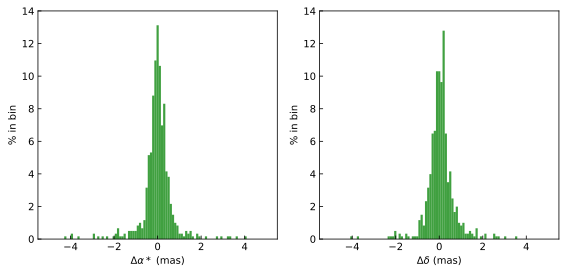

In [11]:
# Difference in RA and decl.
bins_array = np.linspace(-5, 5, 100)
weights = np.ones_like(dRA) * 100. / dRA.size

fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(dRA, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(dDC, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_yticks(np.arange(0, 16, 2))
ax1.set_yticks(np.arange(0, 16, 2))

ax0.set_ylim([0, 14])
ax1.set_ylim([0, 14])

ax0.set_xlabel("$\Delta\\alpha*$ (mas)")
ax1.set_xlabel("$\Delta\\delta$ (mas)")

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

fig.tight_layout()
plt.show()

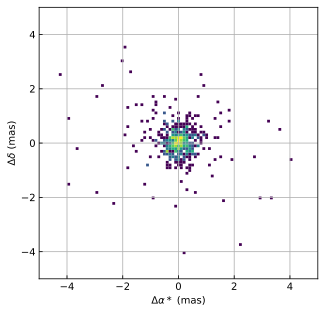

In [12]:
from matplotlib import colors

fig, ax = plt.subplots(figsize=(5, 5))

bins = np.linspace(-5, 5, 100)

# We can increase the number of bins on each axis
ax.hist2d(dRA, dDC, bins, norm=colors.LogNorm())

ax.set_xlabel("$\Delta\\alpha*$ (mas)")
ax.set_ylabel("$\Delta\\delta$ (mas)")

ax.grid(True)

plt.show()

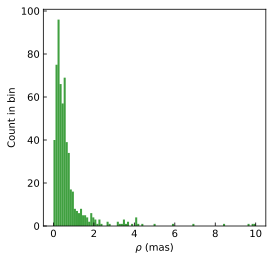

In [13]:
# Distribution of angular separation
bins_array = np.linspace(0, 10, 100)

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(ang_sep, bins_array, facecolor="g", alpha=0.75)

ax.set_xlabel("$\\rho$ (mas)")
ax.set_ylabel("Count in bin")

plt.show()

In [14]:
std_ra = np.std(X_a)
std_dec = np.std(X_d)

std_ra, std_dec

(4.693337262633167, 3.373526736767348)

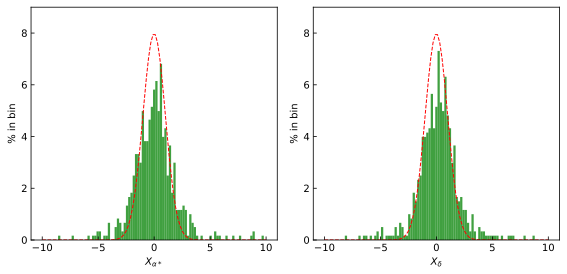

In [15]:
# Normalized difference in RA and decl.
from scipy import stats
bins_array = np.linspace(-10, 10, 100)
weights = np.ones_like(dRA) * 100. / dRA.size

# Plot the 
fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(X_a, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(X_d, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_xlabel("$X_{\\alpha*}$")
ax1.set_xlabel("$X_{\\delta}$")

ax0.set_ylim([0, 9])
ax1.set_ylim([0, 9])

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

# add a '(standard) Gaussian distribution' line
Gaussian_dist = stats.norm.pdf(bins_array, 0, 1) * 10. / 50
ax0.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)
ax1.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)

ax0.set_yticks(np.arange(0, 10, 2))
ax1.set_yticks(np.arange(0, 10, 2))

fig.tight_layout()
plt.show()

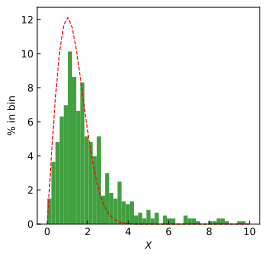

In [16]:
# Distribution of normalized separation
from scipy import stats

bins_array = np.linspace(0, 10, 50)
weights = np.ones_like(X) * 100. / X.size

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(X, bins_array, weights=weights, facecolor="g", alpha=0.75)

# add a '(standard) Rqyleigh distribution' line
rayleigh_dist = stats.rayleigh.pdf(bins_array) * 10. / 50  * 100
ax.plot(bins_array, rayleigh_dist, "r--", linewidth=1)

ax.set_xlabel("$X$")
ax.set_ylabel("% in bin")

plt.show()

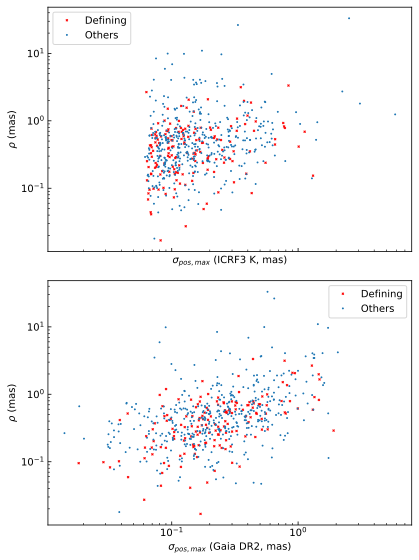

In [17]:
# Angular position difference vs. positional uncertainty
fig, (ax0, ax1) = plt.subplots(figsize=(6, 8), nrows=2, sharex=True)

ax0.plot(com_def["pos_err_icrf3k"],
         com_def["ang_sep"], "rx", ms=2, label="Defining")
ax1.plot(com_def["pos_err_gaiadr2"],
         com_def["ang_sep"], "rx", ms=2, label="Defining")

ax0.plot(com_oth["pos_err_icrf3k"],
         com_oth["ang_sep"], ".", ms=2, label="Others")
ax1.plot(com_oth["pos_err_gaiadr2"],
         com_oth["ang_sep"], ".", ms=2, label="Others")

ax0.set_xscale("log")
ax0.set_yscale("log")
ax1.set_xscale("log")
ax1.set_yscale("log")

ax0.set_xlabel("$\sigma_{pos,max}$ (ICRF3 K, mas)")
ax0.set_ylabel("$\\rho$ (mas)")
ax1.set_xlabel("$\sigma_{pos,max}$ (Gaia DR2, mas)")
ax1.set_ylabel("$\\rho$ (mas)")


ax0.legend()
ax1.legend()

fig.tight_layout()
plt.show()

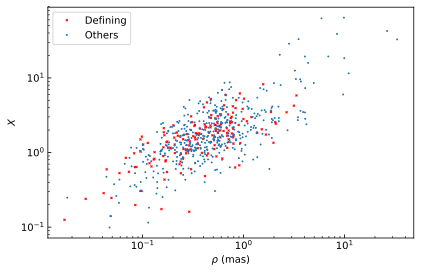

In [18]:
# Angular separation vs. normalized separation
fig, ax = plt.subplots()

ax.plot(com_def["ang_sep"],
         com_def["nor_sep_cov"], "rx", ms=2, label="Defining")
ax.plot(com_oth["ang_sep"],
         com_oth["nor_sep_cov"], ".", ms=2, label="Others")

ax.set_xscale("log")
ax.set_yscale("log")

ax.set_xlabel("$\\rho$ (mas)")
ax.set_ylabel("$X$")

ax.legend()

fig.tight_layout()
plt.show()

Then I investigate the systematics through the 16-parameters transformation.

In [19]:
# Try with all the sources
# Transform columns into np.array
dra = np.array(com_sou["dra"])
ddec = np.array(com_sou["ddec"])
dra_err = np.array(com_sou["dra_err"])
ddec_err = np.array(com_sou["ddec_err"])
ra_rad = np.array(com_sou["ra_icrf3k"].to(u.radian))
dec_rad = np.array(com_sou["dec_icrf3k"].to(u.radian))
dra_ddec_cov = np.array(com_sou["dra_ddec_cov"])

# Transformation parameters
# l_max = 1
w1_all, sig1_all, corrcoef1_all, _, _, _ = vsh_deg01_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
    cov=dra_ddec_cov, elim_flag="None")

# l_max = 2
w2_all, sig2_all, corrcoef2_all, _, _, _ = vsh_deg02_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
    cov=dra_ddec_cov, elim_flag="None")

# mas -> uas
w1 = w1_all * 1.e3
sig1 = sig1_all * 1.e3
w2 = w2_all * 1.e3
sig2 = sig2_all * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "               Rotation [uas]                 "
      "                  Glide [uas]               \n"
      "               x             y             z"
      "               x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "l_max=1  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "l_max=2  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" %
      (dra.size, w1[3], sig1[3], w1[4], sig1[4], w1[5], sig1[5],
       w1[0], sig1[0], w1[1], sig1[1], w1[2], sig1[2],
       w2[3], sig2[3], w2[4], sig2[4], w2[5], sig2[5],
       w2[0], sig2[0], w2[1], sig2[1], w2[2], sig2[2]))

quad_names = Column(["ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_quad = Table([quad_names, w2[6:], sig2[6:]], names=["Quadrupolar term", "Estimate", "Error"])
t_quad["Estimate"].format = "%5.0f"
t_quad["Error"].format = "%5.0f"
print(t_quad)

print("Correlation coefficient between parameters in 'l_max=1' fit")
print_vsh1_corr(corrcoef1_all, deci_digit=1, included_one=False)

print("Correlation coefficient between parameters in 'l_max=2' fit")
print_vsh2_corr(corrcoef2_all, deci_digit=1, included_one=False)

# apriori statistics (weighted)
#         mean for RA:     -0.076 mas
#         wrms for RA:      1.864 mas
#          std for RA:      1.861 mas
#        mean for Dec:      0.039 mas
#        wrms for Dec:      1.171 mas
#         std for Dec:      1.169 mas

# apriori reduced Chi-square for:     16.906
# posteriori statistics  of vsh01 fit (weighted)
#         mean for RA:     -0.076 mas
#          rms for RA:      1.863 mas
#          std for RA:      1.860 mas
#        mean for Dec:     -0.000 mas
#         rms for Dec:      1.170 mas
#         std for Dec:      1.169 mas

# posteriori reduced Chi-square for:     16.780
# goodness-of-fit is      0.000
# apriori statistics (weighted)
#         mean for RA:     -0.076 mas
#         wrms for RA:      1.864 mas
#          std for RA:      1.861 mas
#        mean for Dec:      0.039 mas
#        wrms for Dec:      1.171 mas
#         std for Dec:      1.169 mas

# apriori reduced Chi-square for:     16.906
# posteriori statistics of vsh

In [20]:
# Remove the outlier (consider the normalized separation)
N = len(com_sou)
X0 = np.sqrt(np.log(N) * 2)
# X0 = 3.41

print("There are %d sources.\n"
      "When X >= %.2f, the number of the outlier is smaller than 1." % (N, X0))

mask = ((com_sou["nor_sep_cov"] <= X0)
        & (com_sou["ang_sep"] < 10)
        & (com_sou["pos_err_icrf3k"] < 10)
        & (com_sou["pos_err_gaiadr2"] < 10))

# Table of a clean sample
com_clean = com_sou[mask]

print("After elimination, there are %d sources in the clean sample." % len(com_clean))

There are 602 sources.
When X >= 3.58, the number of the outlier is smaller than 1.
After elimination, there are 513 sources in the clean sample.


In [21]:
# Transform columns into np.array
dra = np.array(com_clean["dra"])
ddec = np.array(com_clean["ddec"])
dra_err = np.array(com_clean["dra_err"])
ddec_err = np.array(com_clean["ddec_err"])
ra_rad = np.array(com_clean["ra_icrf3k"].to(u.radian))
dec_rad = np.array(com_clean["dec_icrf3k"].to(u.radian))
dra_ddec_cov = np.array(com_clean["dra_ddec_cov"])

In [22]:
# Transformation parameters
# l_max = 1
w1_cln, sig1_cln, corrcoef1_cln, _, _, _ = vsh_deg01_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
    cov=dra_ddec_cov, elim_flag="None")

# l_max = 2
w2_cln, sig2_cln, corrcoef2_cln, _, _, _ = vsh_deg02_fitting(
    dra, ddec, ra_rad, dec_rad, dra_err, ddec_err,
    cov=dra_ddec_cov, elim_flag="None")

# mas -> uas
w1 = w1_cln * 1.e3
sig1 = sig1_cln * 1.e3
w2 = w2_cln * 1.e3
sig2 = sig2_cln * 1.e3

# Print results
print("Estimates (%6d sources)\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "               Rotation [uas]                 "
      "                  Glide [uas]               \n"
      "               x             y             z"
      "               x             y             z\n"
      "----------------------------------------------"
      "----------------------------------------------\n"
      "l_max=1  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "l_max=2  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  "
      "  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f  %+4.0f +/- %3.0f\n"
      "----------------------------------------------"
      "----------------------------------------------\n" %
      (dra.size, w1[3], sig1[3], w1[4], sig1[4], w1[5], sig1[5],
       w1[0], sig1[0], w1[1], sig1[1], w1[2], sig1[2],
       w2[3], sig2[3], w2[4], sig2[4], w2[5], sig2[5],
       w2[0], sig2[0], w2[1], sig2[1], w2[2], sig2[2]))

quad_names = Column(["ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_quad = Table([quad_names, w2[6:], sig2[6:]], names=["Quadrupolar term", "Estimate", "Error"])
t_quad["Estimate"].format = "%5.0f"
t_quad["Error"].format = "%5.0f"
print(t_quad)

print("Correlation coefficient between parameters in 'l_max=1' fit")
print_vsh1_corr(corrcoef1_cln, deci_digit=1, included_one=False)

print("Correlation coefficient between parameters in 'l_max=2' fit")
print_vsh2_corr(corrcoef2_cln, deci_digit=1, included_one=False)

# apriori statistics (weighted)
#         mean for RA:      0.007 mas
#         wrms for RA:      0.576 mas
#          std for RA:      0.576 mas
#        mean for Dec:      0.059 mas
#        wrms for Dec:      0.510 mas
#         std for Dec:      0.506 mas

# apriori reduced Chi-square for:      1.551
# posteriori statistics  of vsh01 fit (weighted)
#         mean for RA:      0.008 mas
#          rms for RA:      0.574 mas
#          std for RA:      0.573 mas
#        mean for Dec:      0.036 mas
#         rms for Dec:      0.504 mas
#         std for Dec:      0.502 mas

# posteriori reduced Chi-square for:      1.518
# goodness-of-fit is      0.000
# apriori statistics (weighted)
#         mean for RA:      0.007 mas
#         wrms for RA:      0.576 mas
#          std for RA:      0.576 mas
#        mean for Dec:      0.059 mas
#        wrms for Dec:      0.510 mas
#         std for Dec:      0.506 mas

# apriori reduced Chi-square for:      1.551
# posteriori statistics of vsh

Then I check the residuals of positional offsets.

In [23]:
# Remove the systematics
RA = np.array(com_sou["ra_icrf3k"].to(u.radian))
DE = np.array(com_sou["dec_icrf3k"].to(u.radian))

dra_ns, ddec_ns = residual_calc02(dRA, dDC, RA, DE, w2_cln)
# dra_ns, ddec_ns = residual_calc02(dRA, dDC, RA, DE, w2_all)

# Now re-calculate the normalized difference
ang_sep_ns, Xa_ns, Xd_ns, X_ns, _ = nor_sep(
    dra_ns, dRA_err, ddec_ns, dDC_err, dRA_dDC_cov/dRA_err/dDC_err)

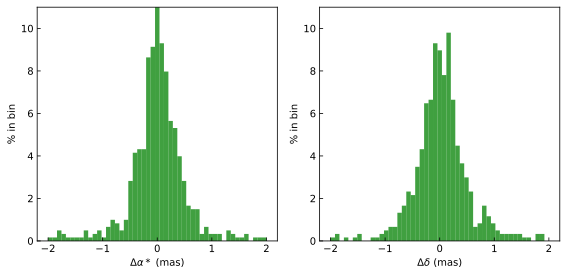

In [24]:
# Difference in RA and decl.
bins_array = np.linspace(-2, 2, 50)
weights = np.ones_like(dra_ns) * 100. / dra_ns.size

fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(dra_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(ddec_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_yticks(np.arange(0, 14, 2))
ax1.set_yticks(np.arange(0, 14, 2))

ax0.set_ylim([0, 11])
ax1.set_ylim([0, 11])
 
ax0.set_xlabel("$\Delta\\alpha*$ (mas)")
ax1.set_xlabel("$\Delta\\delta$ (mas)")

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

fig.tight_layout()
plt.show()

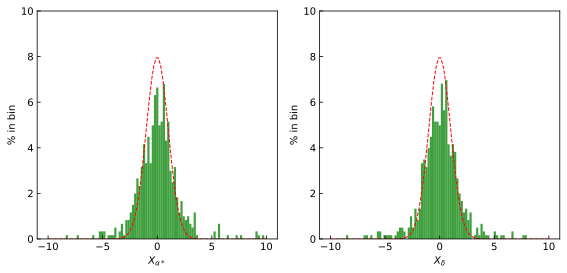

In [25]:
# Normalized difference in RA and decl.
from scipy import stats
bins_array = np.linspace(-10, 10, 100)
weights = np.ones_like(Xa_ns) * 100. / Xa_ns.size

# Plot the 
fig, (ax0, ax1) = plt.subplots(figsize=(8, 4), ncols=2)
ax0.hist(Xa_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)
ax1.hist(Xd_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)

ax0.set_xlabel("$X_{\\alpha*}$")
ax1.set_xlabel("$X_{\\delta}$")

ax0.set_ylabel("% in bin")
ax1.set_ylabel("% in bin")

# add a '(standard) Gaussian distribution' line
Gaussian_dist = stats.norm.pdf(bins_array, 0, 1) * 10. / 50
ax0.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)
ax1.plot(bins_array, Gaussian_dist * 100, "r--", linewidth=1)

ax0.set_yticks(np.arange(0, 11, 2))
ax1.set_yticks(np.arange(0, 11, 2))

fig.tight_layout()
plt.show()

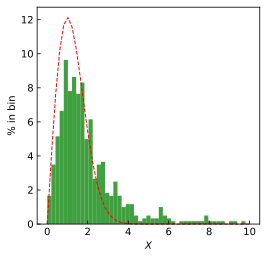

In [26]:
# Distribution of normalized separation
from scipy import stats

bins_array = np.linspace(0, 10, 50)
weights = np.ones_like(X_ns) * 100. / X_ns.size

fig, ax = plt.subplots(figsize=(4, 4))
ax.hist(X_ns, bins_array, weights=weights, facecolor="g", alpha=0.75)

# add a '(standard) Rqyleigh distribution' line
rayleigh_dist = stats.rayleigh.pdf(bins_array) * 10. / 50  * 100
ax.plot(bins_array, rayleigh_dist, "r--", linewidth=1)

ax.set_xlabel("$X$")
ax.set_ylabel("% in bin")

plt.show()

In [27]:
# The last step is to save the 16 transformation parameters for further use.

vsh2_names = Column(["D1", "D2", "D3",
                     "R1", "R2", "R3",
                     "ER22", "EI22", "ER21", "EI21", "E20",
                     "MR22", "MI22", "MR21", "MI21", "M20"])
t_vsh2 = Table([vsh2_names, w2, sig2], names=[
               "Names", "Estimate", "Error"])
t_vsh2["Estimate"].format = "%5.0f"
t_vsh2["Error"].format = "%5.0f"
t_vsh2["Estimate"].unit = u.uas
t_vsh2["Error"].unit = u.uas
t_vsh2.write("../logs/icrf3k_gaiadr2_vsh02.log", format="ascii", overwrite=True)